# Check Which GPU you got

In [ ]:
!nvidia-smi

Wed Apr 27 22:08:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports and CONST

In [1]:
!pip3 install transformers

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

drive.mount('/content/drive/')

DATA_FILE_DIR = "/content/drive/My Drive/NLP-Final/GPT2-News-Classifier/data/"
STATE_FILE_DIR = "/content/drive/My Drive/NLP-Final/"
KEYS_VALUES_PATH = "/content/drive/My Drive/NLP-Final/gpt2_sparse_keys&values/"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 4.0 MB 30.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 
     |████████████████████████████████| 596 kB 62.1 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 895 kB 68.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Mounted at /content/drive/


# Definitions

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.eos_token
        labels = {
            "business": 0,
            "entertainment": 1,
            "sport": 2,
            "tech": 3,
            "politics": 4
                }
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [2]:
class GPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int):
        super(GPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained("gpt2")
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train_model(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

In [ ]:
def eval_model(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

            # send back to cpu
            test_label = test_label.to("cpu")
            mask = test_input['attention_mask'].to("cpu")
            input_id = test_input['input_ids'].squeeze(1).to("cpu")

    test_accuracy = total_acc_test / len(test_data)
    print(f'Test Accuracy: {test_accuracy:.3f}')
    model.cpu()             # send back to cpu
    return test_accuracy


# Fast OMP

In [ ]:
%load_ext Cython

In [ ]:
%%cython

"""Cython allows us to call lower level c-code instead of using Python. It can be a surprisingly big speedup!"""
import cython
from scipy.linalg.cython_blas cimport idamax, isamax, daxpy, dgemv, dtrmv, dcopy
from scipy.linalg.cython_lapack cimport dposv, dppsv, sppsv

ctypedef fused proj_t:
    double
    float

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void ppsv(proj_t[:, :] As,
           proj_t[:, :, :] ys) nogil:
    # Works not for strided array I think. And please do not give a negative-stride array.
    cdef Py_ssize_t B = ys.shape[0]  # Batch size
    cdef int N = ys.shape[1]
    cdef int nrhs = ys.shape[2]
    cdef int info = 0  # Just discard any error signals ;)
    cdef char uplo = 85 # The letter 'U', since we store the lower triangle and fortran sees As.T.
    # cdef int ldb = ys[0].strides[0] // sizeof(double)

    for i from 0 <= i < B:
        if proj_t is double:  # One C-function is created for each of these specializations! :) (see argmax_blast.__signatures__)
            dppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)
        elif proj_t is float:
            sppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void argmax_blast(proj_t[:, :] projections,
                 long long[:] output) nogil:
    # TODO: Numpy has its own indexing data-type - this may be a more appropriate output, and may even be faster.
    # http://conference.scipy.org/static/wiki/seljebotn_cython.pdf
    # https://apprize.best/python/cython/3.html
    cdef Py_ssize_t B = projections.shape[0]
    cdef int N = projections.shape[1]
    cdef int incx = projections.strides[1] // sizeof(proj_t)  # Stride between elements.
    cdef Py_ssize_t i
    for i from 0 <= i < B:
        if proj_t is double:
            output[i] = idamax(&N, &projections[i, 0], &incx) - 1
        elif proj_t is float:
            output[i] = isamax(&N, &projections[i, 0], &incx) - 1

In [ ]:
"""This cell contains the code we've implemented. You should be able to call each function directly, or alternatively, see our example calls below"""

import os
import torch
import torch.utils
import torch.utils.data
from sklearn.datasets import make_sparse_coded_signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from contextlib import contextmanager
from timeit import default_timer
# from test_omp import omp_naive
# from test import *  # FIXME: better name
# from line_profiler import line_profiler

n_components, n_features = 100, 100
n_nonzero_coefs = 17
n_samples = 50

@contextmanager
def elapsed_timer():
    # https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start


def run_omp(X, y, n_nonzero_coefs, precompute=True, tol=0.0, normalize=False, fit_intercept=False, alg='naive'):
    if not isinstance(X, torch.Tensor):
        X = torch.as_tensor(X)
        y = torch.as_tensor(y)

    # We can either return sets, (sets, solutions), or xests
    # These are all equivalent, but are simply more and more dense representations.
    # Given sets and X and y one can (re-)construct xests. The second is just a sparse vector repr.

    # https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L690
    if fit_intercept or normalize:
        X = X.clone()
        assert not isinstance(precompute, torch.Tensor), "If user pre-computes XTX they can also pre-normalize X" \
                                                         " as well, so normalize and fit_intercept must be set false."

    if fit_intercept:
        X = X - X.mean(0)
        y = y - y.mean(1)[:, None]

    # To keep a good condition number on X, especially with Cholesky compared to LU factorization,
    # we should probably always normalize it (OMP is invariant anyways)
    if normalize is True:  # User can also just optionally supply pre-computed norms.
        normalize = (X * X).sum(0).sqrt()
        X /= normalize[None, :]

    if precompute is True or alg == 'v0':
        precompute = X.T @ X

    # If n_nonzero_coefs is equal to M, one should just return lstsq
    if alg == 'naive':
        sets, solutions, lengths = omp_naive(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)
    elif alg == 'v0':
        sets, solutions, lengths = omp_v0(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)


    solutions = solutions.squeeze(-1)
    if normalize is not False:
        solutions /= normalize[sets]

    xests = y.new_zeros(y.shape[0], X.shape[1])
    if lengths is None:
        xests[torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)[:, None], sets] = solutions
    else:
        for i in range(y.shape[0]):
            # xests[i].scatter_(-1, sets[i, :lengths[i]], solutions[i, :lengths[i]])
            xests[i, sets[i, :lengths[i]]] = solutions[i, :lengths[i]]

    return xests

def batch_mm(matrix, matrix_batch, return_contiguous=True):
    """
    :param matrix: Sparse or dense matrix, size (m, n).
    :param matrix_batch: Batched dense matrices, size (b, n, k).
    :return: The batched matrix-matrix product, size (m, n) x (b, n, k) = (b, m, k).
    """
    # One dgemm is faster than many dgemv.
    # From https://github.com/pytorch/pytorch/issues/14489#issuecomment-607730242
    batch_size = matrix_batch.shape[0]
    # Stack the vector batch into columns. (b, n, k) -> (n, b, k) -> (n, b*k)
    vectors = matrix_batch.transpose([1, 0, 2]).reshape(matrix.shape[1], -1)

    # A matrix-matrix product is a batched matrix-vector product of the columns.
    # And then reverse the reshaping. (m, n) x (n, b*k) = (m, b*k) -> (m, b, k) -> (b, m, k)
    if return_contiguous:
        result = np.empty_like(matrix_batch, shape=(batch_size, matrix.shape[0], matrix_batch.shape[2]))
        np.matmul(matrix, vectors, out=result.transpose([1, 0, 2]).reshape(matrix.shape[0], -1))
    else:
        result = (matrix @ vectors).reshape(matrix.shape[0], batch_size, -1).transpose([1, 0, 2])

    return result


def innerp(x, y=None, out=None):
    if y is None:
        y = x
    if out is not None:
        out = out[:, None, None]  # Add space for two singleton dimensions.
    return torch.matmul(x[..., None, :], y[..., :, None], out=out)[..., 0, 0]

def cholesky_solve(ATA, ATy):
    if ATA.dtype == torch.half or ATy.dtype == torch.half:
        return ATy.to(torch.float).cholesky_solve(torch.cholesky(ATA.to(torch.float))).to(ATy.dtype)
    return ATy.cholesky_solve(torch.cholesky(ATA)).to(ATy.dtype)


def omp_naive(X, y, n_nonzero_coefs, tol=None, XTX=None):
    on_cpu = not (y.is_cuda or y.dtype == torch.half)
    # torch.cuda.synchronize()
    # Given X as an MxN array and y as an BxN array, do omp to approximately solve Xb=y

    # Base variables
    XT = X.contiguous().t()  # Store XT in fortran-order.
    y = y.contiguous()
    r = y.clone()

    sets = y.new_zeros((n_nonzero_coefs, y.shape[0]), dtype=torch.long).t()
    if tol:
        result_sets = sets.new_zeros(y.shape[0], n_nonzero_coefs)
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        original_indices = torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)

    # Trade b*k^2+bk+bkM = O(bkM) memory for much less compute time. (This has to be done anyways since we are batching,
    # otherwise one could just permute columns of X in-place as in https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L28 )
    ATs = y.new_zeros(r.shape[0], n_nonzero_coefs, X.shape[0])
    ATys = y.new_zeros(r.shape[0], n_nonzero_coefs, 1)
    ATAs = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device)[None].repeat(r.shape[0], 1, 1)
    if on_cpu:
        # For CPU it is faster to use a packed representation of the lower triangle in ATA.
        tri_idx = torch.tril_indices(n_nonzero_coefs, n_nonzero_coefs, device=sets.device, dtype=sets.dtype)
        ATAs = ATAs[:, tri_idx[0], tri_idx[1]]

    solutions = y.new_zeros((r.shape[0], 0))

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = innerp(r) <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                remaining = ~problems_done

                orig_idxs = original_indices[problems_done]
                result_sets[orig_idxs, :k] = sets[problems_done, :k]
                result_solutions[orig_idxs, :k] = solutions[problems_done]
                result_lengths[orig_idxs] = k
                original_indices = original_indices[remaining]

                # original_indices = original_indices[remaining]
                ATs = ATs[remaining]
                ATys = ATys[remaining]
                ATAs = ATAs[remaining]
                sets = sets[remaining]
                y = y[remaining]
                r = r[remaining]
                if problems_done.all():
                    return result_sets, result_solutions, result_lengths
        # GET PROJECTIONS AND INDICES TO ADD
        if on_cpu:
            projections = batch_mm(XT.numpy(), r[:, :, None].numpy())
            argmax_blast(projections.squeeze(-1), sets[:, k].numpy())
        else:
            projections = XT @ r[:, :, None]
            sets[:, k] = projections.abs().sum(-1).argmax(-1)  # Sum is just a squeeze, but would be relevant in SOMP.

        # UPDATE AT
        AT = ATs[:, :k + 1, :]
        updateA = XT[sets[:, k], :]
        AT[:, k, :] = updateA

        # UPDATE ATy based on AT
        ATy = ATys[:, :k + 1]
        innerp(updateA, y, out=ATy[:, k, 0])

        # UPDATE ATA based on AT or precomputed XTX.
        if on_cpu:
            packed_idx = k * (k - 1) // 2
            if XTX is not None:  # Update based on precomputed XTX.
                ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t().numpy()[:] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                np.matmul(AT[:, :k + 1, :].numpy(), updateA[:, :, None].numpy(),
                          out=ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t()[:, :, None].numpy())
        else:
            ATA = ATAs[:, :k + 1, :k + 1]
            if XTX is not None:
                ATA[:, k, :k + 1] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                # Update ATAs by adding the new column of inner products.
                torch.bmm(AT[:, :k + 1, :], updateA[:, :, None], out=ATA[:, k, :k + 1, None])

        # SOLVE ATAx = ATy.
        if on_cpu:
            solutions = ATy.permute(0, 2, 1).clone().permute(0, 2, 1)  # Get a copy.
            ppsv(ATAs.t()[:packed_idx + 2 * k + 1, :].t().contiguous().numpy(), solutions.numpy())
        else:
            ATA[:, :k, k] = ATA[:, k, :k]  # Copy lower triangle to upper triangle.
            solutions = cholesky_solve(ATA, ATy)

        # FINALLY, GET NEW RESIDUAL r=y-Ax
        if on_cpu:
            np.subtract(y.numpy(), (AT.permute(0, 2, 1).numpy() @ solutions.numpy()).squeeze(-1), out=r.numpy())
        else:
            torch.baddbmm(y[:, :, None], AT.permute(0, 2, 1), solutions, beta=-1, out=r[:, :, None])

    return sets, solutions, None

def omp_v0(X, y, XTX, n_nonzero_coefs=None, tol=None, inverse_cholesky=True):
    B = y.shape[0]
    normr2 = innerp(y)  # Norm squared of residual.
    projections = (X.transpose(1, 0) @ y[:, :, None]).squeeze(-1)
    sets = y.new_zeros(n_nonzero_coefs, B, dtype=torch.int64)

    if inverse_cholesky:
        # Doing the inverse-cholesky iteratively uses more memory,
        # but takes less time than waiting till solving the problem in the end it seems.
        # (Since F is triangular it could be __even faster__ to multiply, prob. not on GPU tho.)
        F = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device).repeat(B, 1, 1)
        a_F = y.new_zeros(n_nonzero_coefs, B, 1)

    D_mybest = y.new_empty(B, n_nonzero_coefs, XTX.shape[0])
    temp_F_k_k = y.new_ones((B, 1))

    if tol:
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        finished_problems = sets.new_zeros(y.shape[0], dtype=torch.bool)

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = normr2 <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                new_problems_done = problems_done & ~finished_problems
                finished_problems.logical_or_(problems_done)
                result_lengths[new_problems_done] = k
                if inverse_cholesky:
                    result_solutions[new_problems_done, :k] = F[new_problems_done, :k, :k].permute(0, 2, 1) @ a_F[:k, new_problems_done].permute(1, 0, 2)
                else:
                    assert False, "inverse_cholesky=False with tol != None is not handled yet"
                if problems_done.all():
                    return sets.t(), result_solutions, result_lengths

        sets[k] = projections.abs().argmax(1)
        # D_mybest[:, k, :] = XTX[gamma[k], :]  # Same line as below, but significantly slower. (prob. due to the intermediate array creation)
        torch.gather(XTX, 0, sets[k, :, None].expand(-1, XTX.shape[1]), out=D_mybest[:, k, :])
        if k:
            D_mybest_maxindices = D_mybest.permute(0, 2, 1)[torch.arange(D_mybest.shape[0], dtype=sets.dtype, device=sets.device), sets[k], :k]
            torch.rsqrt(1 - innerp(D_mybest_maxindices),
                        out=temp_F_k_k[:, 0])  # torch.exp(-1/2 * torch.log1p(-inp), temp_F_k_k[:, 0])
            D_mybest_maxindices *= -temp_F_k_k  # minimal operations, exploit linearity
            D_mybest[:, k, :] *= temp_F_k_k
            D_mybest[:, k, :, None].baddbmm_(D_mybest[:, :k, :].permute(0, 2, 1), D_mybest_maxindices[:, :, None])


        temp_a_F = temp_F_k_k * torch.gather(projections, 1, sets[k, :, None])
        normr2 -= (temp_a_F * temp_a_F).squeeze(-1)
        projections -= temp_a_F * D_mybest[:, k, :]
        if inverse_cholesky:
            a_F[k] = temp_a_F
            if k:  # Could maybe get a speedup from triangular mat mul kernel.
                torch.bmm(D_mybest_maxindices[:, None, :], F[:, :k, :], out=F[:, k, None, :])
                F[:, k, k] = temp_F_k_k[..., 0]
    else: # FIXME: else branch will not execute if n_nonzero_coefs=0, so solutions is undefined.
        # Normal exit, used when tolerance=None.
        if inverse_cholesky:
            solutions = F.permute(0, 2, 1) @ a_F.squeeze(-1).transpose(1, 0)[:, :, None]
        else:
            # Solving the problem in the end without using inverse Cholesky.
            AT = X.T[sets.T]
            solutions = cholesky_solve(AT @ AT.permute(0, 2, 1), AT @ y.T[:, :, None])

    return sets.t(), solutions, None

# Sparse Keys & Values Analysis

In [6]:
from numpy import loadtxt
from transformers import GPT2Tokenizer
import torch

KEYS_VALUES_PATH = "./gpt2_omp_results/"
layer_num = 0

gpt2_analysis = GPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128)
gpt2_analysis.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt"))

gpt2_analysis_st = gpt2_analysis.gpt2model.state_dict() # model state dictionary
keys = gpt2_analysis_st[f"h.{layer_num}.mlp.c_fc.weight"].detach().to(device)
values = gpt2_analysis_st[f"h.{layer_num}.mlp.c_proj.weight"].detach().to(device)

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

print(f"Results for GPT2 - Layer {layer_num} - Without Sparsity")
print(f"-----------------------------------------")

for i in range(100):
  sorted_keys, indices_keys = torch.sort(torch.abs(keys[i]), descending=True)
  print("Key: ", gpt2_tokenizer.batch_decode(indices_keys[0:10]))

  sorted_values, indices_values = torch.sort(torch.abs(values[i]), descending=True)
  print("Value: ", gpt2_tokenizer.batch_decode(indices_values[0:10]))
  print("#################################################")

Results for GPT2 - Layer 0 - Without Sparsity
-----------------------------------------
Key:  ['�', ' hum', 'idence', '01', ' user', ' space', ' kn', ' am', 'the', ' country']
Value:  [' time', '�', "'", ' In', '�', '\r', '_', ' w', ' or', ' also']
#################################################
Key:  [' sim', 'ead', ' commun', ' mean', 'arn', 'orld', 'ote', 'ising', ' boy', ' Euro']
Value:  ['rom', ' there', '~', 'ject', '�', ' rec', 'iv', ' just', '�', ' back']
#################################################
Key:  [' been', 'amer', ' foot', 'ally', ' mean', 'ches', 'iol', ' rad', 'osing', 'ters']
Value:  ['�', "'t", 'ents', '�', 'age', '01', 'ld', '\x05', ' new', '�']
#################################################
Key:  ['ches', ' sw', 'OM', ' drug', ' old', 'ics', 'aint', '�', 'ulation', ' started']
Value:  [' may', '>', ' comp', '�', ' st', ' It', 'ay', ' fe', 's', 'ub']
#################################################
Key:  ['aid', ' mem', 'ible', 'eng', '#', ' inst', ' si

In [ ]:
from numpy import savetxt
LAYER_NUM = 10

# Load fine-tuned GPT2
gpt2_analysis = GPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128)
gpt2_analysis.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt"))

# for name,x in gpt2_analysis.named_parameters():
   # if "mlp.c_fc.weight" in name: # c_fc is the feed forward part of the layer 
      # print(name)

# Get embeddings and BERT state
embeddings = gpt2_analysis.gpt2model.get_input_embeddings()
E = embeddings.weight.detach().to(device)
gpt2_analysis_st = gpt2_analysis.gpt2model.state_dict() # model state dictionary

# Compute sparse keys
keys = gpt2_analysis_st[f"h.{LAYER_NUM}.mlp.c_fc.weight"].detach().to(device)
n_non_zero_keys = max(int(0.1 * keys.shape[0]), 1)
sparse_keys = run_omp(E.T,  keys.T, n_non_zero_keys) # run optimized OMP
savetxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_keys.csv", sparse_keys, delimiter=',')

# Compute sparse values
values = gpt2_analysis_st[f"h.{LAYER_NUM}.mlp.c_proj.weight"].detach().to(device)
n_non_zero_values = max(int(0.1 * values.shape[1]), 1)
sparse_values = run_omp(E.T,  values.T, n_non_zero_values) # run optimized OMP
savetxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_values.csv", sparse_values, delimiter=',')

In [ ]:
from numpy import loadtxt
LAYER_NUM = 11

sparse_keys = loadtxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_keys.csv", delimiter=',').astype("double")
sparse_keys = torch.from_numpy(sparse_keys).to(device)
sparse_values = loadtxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_values.csv", delimiter=',').astype("double")
sparse_values = torch.from_numpy(sparse_values).to(device)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
i = 0

for i in range(100):
  # non_zero_keys = torch.nonzero(sparse_keys[i])
  sorted_keys, indices_keys = torch.sort(torch.abs(sparse_keys[i]), descending=True)
  print(tokenizer.batch_decode(indices_keys[0:10]))

  # non_zero_values = torch.nonzero(sparse_values[i])
  sorted_values, indices_values = torch.sort(torch.abs(sparse_values[i]), descending=True)
  print(tokenizer.batch_decode(indices_values[0:10]))
  # print(tokenizer.batch_decode(non_zero_values))
  print("#################################################")

(0.0, 1.0900326609611513)

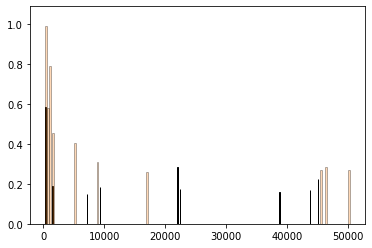

In [ ]:
import matplotlib.pyplot as plt

# Show Relation in Histogram
plt.bar(indices_keys[:76].cpu().numpy(),sorted_keys[:76].cpu().numpy(), width=indices_keys[:76].cpu()[1]-indices_keys[:76].cpu()[0], ec='k', lw=1)
plt.ylim(0, max(sorted_keys[:76].cpu().numpy())*1.1)
plt.bar(indices_values[:76].cpu().numpy(),sorted_values[:76].cpu().numpy(), width=indices_values[:76].cpu()[2]-indices_values[:76].cpu()[1], ec='k', lw=1, alpha=0.1)
plt.ylim(0, max(sorted_values[:76].cpu().numpy())*1.1)

# TODO: show relation in embedding space plot


In [ ]:
from transformers import GPT2LMHeadModel
import torch.nn.functional as F
model = GPT2LMHeadModel.from_pretrained('gpt2')

inputs = tokenizer(tokenizer.decode(indices_values[0]), return_tensors='pt')
outputs = model(**inputs)

# If you are not on a source install, replace outputs.logits by outputs[0]
predictions = F.softmax(outputs[0], dim=-1)

thresh = 1e-2
vocab_size = predictions.shape[-1]

# Predictions has one sentence (index 0) and we look at the last token predicted (-1)
idxs = torch.arange(0, vocab_size)[predictions[0][-1] >= thresh]
print(tokenizer.convert_ids_to_tokens(idxs))


[',', '.', 'Ċ', 'Ġa', 'Ġthe', 'Ġto', 'Ġof', 'Ġin', 'Ġand', 'Ġbe', 'Ġnot', 'Ġhave']


#Load and Eval

In [ ]:
df = pd.read_csv(DATA_FILE_DIR + 'bbc-text.csv')
# df = pd.read_csv(DATA_FILE_DIR + 'bbc-text-small.csv') # smaller dataset to save training time.

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])
print(len(df_train), len(df_val), len(df_test))


# load trained model
gpt2_fast_omp = GPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128)
gpt2_fast_omp.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt"))
gpt2_fast_omp.eval()
test_accuracy = eval_model(gpt2_fast_omp, df_test)


1780 222 223
Test Accuracy: 0.946




---


#10% of Coefficients are Non-zero - TESTS

**GPT2 Test - Replace each layer untouching the others**

```
  gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # GPT2 model state dictionary
  y_tensor = gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"].detach().to(device) # get weights for ith ff layer 

```



In [ ]:
torch.cuda.empty_cache()
# Replace every state untouching the others
emb1 = gpt2_fast_omp.gpt2model.get_input_embeddings() # embeddings
gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]
n_non_zero = max(int(0.1 * num_features), 1) # 10% of X num of features

exp_results = dict()


for i in range(13):
  torch.cuda.empty_cache() # Clear memory
  gpt2_fast_omp.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt")) # load trained weights

  if i == 0:
    print("Results Before Replacement")
    res = eval_model(gpt2_fast_omp, df_test)
    exp_results[f'No_Replace'] = res
    continue

  gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # GPT2 model state dictionary
  y_tensor = gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"].detach().to(device) # get weights for ith ff layer 

  xes = run_omp(X_tensor,  y_tensor, n_non_zero) # run fast OMP

  temp_weights = xes @ X_tensor # matrix mult to get the weights

  gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"]  = temp_weights
  gpt2_fast_omp.gpt2model.load_state_dict(gpt2_fast_omp_st)
  print(f"Results for layer-{i-1} Weights Replacement")
  res = eval_model(gpt2_fast_omp, df_test)
  exp_results[f'layer-{i-1}'] = res


  y_tensor.to("cpu")

pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/GPT2/Replace_each_layer_leaving_others_untouched.xlsx')

Results Before Replacement
Test Accuracy: 0.946


RuntimeError: ignored

**BERT Test - Replace layers one by one together**

```
    y_tensor = bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

```


In [ ]:
#  Replace layers one by one together
emb1 = gpt2_fast_omp.gpt2model.get_input_embeddings() # embeddings
gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]

ratios = [0.01,0.02,0.05,0.1,0.15,0.2,0.25]
for j in ratios:
  n_non_zero = max(int(j * num_features), 1)+1 # 10% of X num of features

  print(f'{100*j:.2f}% Sparsity - {n_non_zero} coef.')
  exp_results = dict()
  for i in range(13):
    torch.cuda.empty_cache() # Clear memory
    gpt2_fast_omp.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt")) # load trained weights

    if i == 0:
      print("Results Before Replacement")
      res = eval_model(gpt2_fast_omp, df_test)
      exp_results[f'No_Replace'] = res
      continue

    # gpt2_fast_omp_st is updated every step
    y_tensor = gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"].detach().to(device) # get weights for ith ff layer 

    xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

    temp_weights = xes @ X_tensor # matrix mult to get the weights

    gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"]  = temp_weights
    gpt2_fast_omp.gpt2model.load_state_dict(gpt2_fast_omp_st)
    print(f"Results for Replacing all the layers up to layer-{i-1} (included) ")
    res = eval_model(gpt2_fast_omp, df_test)
    exp_results[f'layer0_to_{i}'] = res

  pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/GPT2/Replace_layers_one_by_one_{100*j:.2f}_percent_{n_non_zero}_coef.xlsx')

#Different Sparsity Levels - Run Alone - No GPU Memory for all the EXP together - TESTS

**GPT2 Test - Replace only for each layer untouching others, and change num of Non Zero Coefficients**


```
  # Change ratio of non_zero_coef each iteration
  n_non_zero = max(int(ratio * num_features), 1) # ratio of X num of features
```



In [ ]:
# 1%-45%
import gc 
emb1 = gpt2_fast_omp.gpt2model.get_input_embeddings() # embeddings
gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]

exp_results = dict()

ratios = [0.0,0.01,0.05,0.1,0.15,0.2,0.3,0.35,0.4,0.45]

for j in range (12):
  gc.collect()
  exp_results = dict()
  for i, ratio in enumerate(ratios):
    # Change ratio of non_zero_coef each iteration
    n_non_zero = max(int(ratio * num_features), 1) # ratio of X num of features
    torch.cuda.empty_cache() # Clear memory
    
    gpt2_fast_omp.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt")) # load trained weights

    if i == 0: # print baseline results first
      print("Results Before Replacement")
      res = eval_model(gpt2_fast_omp, df_test)
      exp_results[f'No_Replace'] = res
      continue

    gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # model state dictionary
    y_tensor = gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"].detach().to(device) # get weights for ith ff layer 

    xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

    temp_weights = xes @ X_tensor # matrix mult to get the weights

    gpt2_fast_omp_st[f"h.{i-1}.mlp.c_fc.weight"]  = temp_weights
    gpt2_fast_omp.gpt2model.load_state_dict(gpt2_fast_omp_st)
    print(f"Results for layer-{j} Weights Replacement with {100*ratio:.2f}% Non-Zero Coefficients")

    res = eval_model(gpt2_fast_omp, df_test)
    exp_results[f'layer0_to_{i}'] = res
    y_tensor.to("cpu")

  pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/GPT2/Sparsity_Levels_1_45_layer{j}.xlsx')




Results Before Replacement


KeyboardInterrupt: ignored

#Train

In [ ]:
df = pd.read_csv(DATA_FILE_DIR + 'bbc-text.csv')
# df = pd.read_csv(DATA_FILE_DIR + 'bbc-text-small.csv') # smaller dataset to save training time.

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])
print(len(df_train), len(df_val), len(df_test))

EPOCHS = 2
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train_model(model, df_train, df_val, LR, EPOCHS)

true_labels, pred_labels = eval_model(model, df_test)

In [ ]:
# save trained model
torch.save(model.state_dict(), STATE_FILE_DIR+"gpt2_state_w_finetuning.pt")

# SKlearn Test

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

emb1 = gpt2.gpt2model.get_input_embeddings() # embeddings
X = emb1.weight.detach()
num_features = X.shape[1]
n_non_zero = max(int(0.1 * num_features), 1) # 10% of X num of features

gpt2_st = gpt2.gpt2model.state_dict() # model state dictionary

torch.cuda.empty_cache() # Clear memory

y = gpt2_st[f"h.0.mlp.c_fc.weight"].detach() # get weights for 0 ff layer
reg = OrthogonalMatchingPursuit(normalize=False).fit(X.T.cpu(),  y.cpu())
xes = reg.predict(X.T)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  X, y[:, k], n_nonzero_coefs, tol, copy_X=copy_X, return_path=return_path


In [ ]:
from numpy import savetxt, loadtxt
savetxt(f"/content/drive/MyDrive/NLP-Final/results_omp_gpt2_layer0.csv", xes, delimiter=',')

In [ ]:
def print_layers_params(model):
  for name,x in model.named_parameters():
   # if "mlp.c_fc.weight" in name: # c_fc is the feed forward part of the layer 
      print(name)

print_layers_params(model_new)

gpt2model.h.0.mlp.c_fc.weight
gpt2model.h.1.mlp.c_fc.weight
gpt2model.h.2.mlp.c_fc.weight
gpt2model.h.3.mlp.c_fc.weight
gpt2model.h.4.mlp.c_fc.weight
gpt2model.h.5.mlp.c_fc.weight
gpt2model.h.6.mlp.c_fc.weight
gpt2model.h.7.mlp.c_fc.weight
gpt2model.h.8.mlp.c_fc.weight
gpt2model.h.9.mlp.c_fc.weight
gpt2model.h.10.mlp.c_fc.weight
gpt2model.h.11.mlp.c_fc.weight


# Fast OMP Test

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

gpt2_fast_omp = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128)
gpt2_fast_omp.load_state_dict(torch.load(STATE_FILE_DIR+"gpt2_state_w_finetuning.pt"))
gpt2_fast_omp.eval()

emb1 = gpt2_fast_omp.gpt2model.get_input_embeddings() # embeddings
X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]
n_non_zero = max(int(0.1 * num_features), 1) # 10% of X num of features

gpt2_fast_omp_st = gpt2_fast_omp.gpt2model.state_dict() # model state dictionary

torch.cuda.empty_cache() # Clear memory

y_tensor = gpt2_fast_omp_st[f"h.0.mlp.c_fc.weight"].detach().to(device) # get weights for 0 ff layer

xes = run_omp(X_tensor.T,  y_tensor.T, n_non_zero) # run fast OMP
temp_weights = xes @ X_tensor # matrix mult to get the weights

cuda


RuntimeError: ignored

In [ ]:
gpt2_fast_omp_st[f"h.0.mlp.c_fc.weight"]  = temp_weights.T
gpt2_fast_omp.gpt2model.load_state_dict(gpt2_fast_omp_st)
print(f"Results for layer 0 Weights Replacement")

Results for layer 0 Weights Replacement


TypeError: ignored

In [ ]:
df = pd.read_csv(DATA_FILE_DIR + 'bbc-text.csv')
# df = pd.read_csv(DATA_FILE_DIR + 'bbc-text-small.csv') # smaller dataset to save training time.

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])
test_accuracy = eval_model(gpt2_fast_omp, df_test)

Test Accuracy:  0.946
